# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__16 марта 00:00__</span>.

Мягкий дедлайн: <span style="color:red">__30 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `Unet` и `Linknet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [12]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt

import torchvision
from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline

#this command don't work in colab
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

%config InlineBackend.figure_format = 'svg'

In [13]:
import os

In [3]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        # your code here
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms
        self.imgs = sorted(os.listdir(path=self.images_dir))
        if (target_dir is not None):
            self.masks = sorted(os.listdir(path=self.target_dir))
        
    def __len__(self):
        # your code here
        return len(self.imgs)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        # your code here
        image = torchvision.io.read_image(self.images_dir + self.imgs[idx]).type(torch.float)
        image = image / 255
        if (self.target_dir):
            mask = torchvision.io.read_image(self.target_dir + self.masks[idx]).float() / 255
        else:
            mask = None
        if self.transforms is not None:
            for t in self.transforms:
                image, mask = t(image, mask)
        return image, mask

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

In [4]:
from torchvision.transforms import functional as F

In [5]:
class HorizontalFlip(object):
    def __init__(self, p=0):
        self.p = p

    def __call__(self, img, mask):
        if torch.rand(1) < self.p:
            if mask is not None:
                return F.hflip(img), F.hflip(mask)
            else:
                return F.hflip(img), None
        return img, mask

In [6]:
class ColorJitter(object):
    def __init__(self, p=0, brightness=0):
        self.p = p
        self.brightness_factor = np.random.uniform(max(0,1 - brightness), 1 + brightness, 1)

    def __call__(self, img, mask):
        if torch.rand(1) < self.p:
            return F.adjust_brightness(img, self.brightness_factor), mask
        return img, mask

In [7]:
class DeletePart(object):
    def __init__(self, p=0, size=None):
        self.p = p
        self.size = size

    def __call__(self, img, mask):
        if self.size is None:
              self.size = np.random.randint(1, min(img.shape[1], img.shape[1]))
        if torch.rand(1) < self.p:
            matr = torch.ones(img.shape[1], img.shape[2])
            x = np.random.randint(0, min(img.shape[1], img.shape[2]) - self.size)
            y = np.random.randint(0, min(img.shape[1], img.shape[2]) - self.size)
            matr[x:x+self.size, y:y+self.size] = 0
            if mask is not None:
                return img*matr, matr*mask
            else:
                return img*matr, None
        return img, mask

In [8]:
class ChangeBack(object):
    def __init__(self, p=0, pictures=None):
        self.p = p
        self.pictures = pictures

    def __call__(self, img, mask):
        if (torch.rand(1) < self.p) & (self.pictures is not None):
            idx = np.random.randint(0, len(self.pictures)-1)
            img[:, mask[0]==0] = self.pictures[idx][:, mask[0]==0]
        return img, mask

In [9]:
class Normalize(object):
    def __init__(self, mean, std):
        self.norm = torchvision.transforms.Normalize(mean=mean, std=std)

    def __call__(self, img, mask):
        return self.norm(img), mask

In [10]:
class ToTensor(object):
    def __init__(self):
        self.tensor = torchvision.transforms.ToTensor()

    def __call__(self, img, mask):
        if mask is not None:
            return self.tensor(img), self.tensor(mask)
        else:
            return self.tensor(img), None

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
pictures = []
images_dir = '../content/drive/MyDrive/back/'
l = os.listdir(path=images_dir)
for i in range(len(l)):
    pictures.append(torchvision.transforms.Resize((320, 240))(torchvision.io.read_image(images_dir + l[i]).type(torch.float)) / 255)

In [16]:
DATA_PATH = '../content/drive/MyDrive/people_data/'

train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= [HorizontalFlip(0.5),
                 ColorJitter(0.5, 0.5),
                 ChangeBack(0.5, pictures),
                 DeletePart(0.5, 35),
                 Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms= [Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

Функция для отображения изображения:

In [17]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

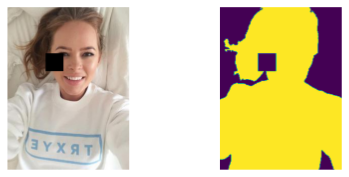

In [ ]:
show_idx_image(train_dataset, 0)

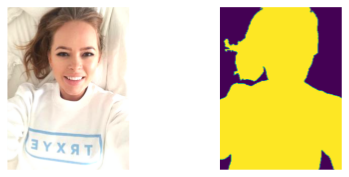

In [ ]:
show_idx_image(train_dataset, 0)

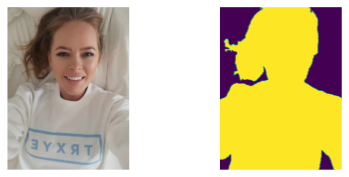

In [ ]:
# your code here
show_idx_image(train_dataset, 0)

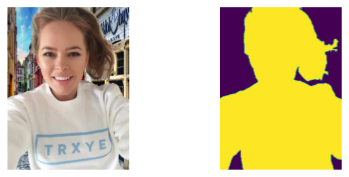

In [ ]:
show_idx_image(train_dataset, 0)

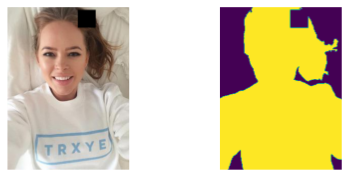

In [ ]:
show_idx_image(train_dataset, 0)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

In [18]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=16)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        # your code here
        axis = len(logits.shape)
        numenator = 2*(true_labels * logits).sum(axis=axis-1).sum(axis=axis-2)
        denominator = (true_labels + logits + self.eps).sum(axis=axis-1).sum(axis=axis-2)
        if self.reduction == 'sum':
            loss_value = (1 - numenator/denominator).sum()
        elif self.reduction == 'mean':
            loss_value = (1 - numenator/denominator).mean()
        elif self.reduction is None:
            loss_value = (1 - numenator/denominator)
            
        return loss_value

Проверка реализации:

In [ ]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать [UNet](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`. Архитектура сети реализована за вас ниже.

Энкодер:

In [ ]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[
                    feature_extractor[j]
                    for j in range(i * 5, i * 5 + 4)
                ])
            )

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [ ]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [ ]:
class IOU(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        mask = torch.sigmoid(logits) > 0.5
        logits[mask], logits[~mask] = 1, 0
        union = logits + true_labels
        axis = len(logits.shape)
        denominator = (union > 0).sum(axis=axis-1).sum(axis=axis-2)
        return ((logits*true_labels).sum(axis=axis-1).sum(axis=axis-2) / denominator).sum()

In [ ]:
def train(model, trainloader, testloader, num_epoch, criterion, val_criterion, optimizer, device='cpu'):
    train_loss, train_metric, test_loss, test_metric = [], [], [], []
    for epoch in range(num_epoch):
        loss_stat, correct_stat = 0., 0.
        total = 0.
        for images, labels in trainloader:
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_stat += loss.item()
            loss.backward()
            optimizer.step()

            total += labels.size(0)
            correct_stat += float(val_criterion(outputs, labels).detach())

        train_loss.append(loss_stat/total)
        train_metric.append(correct_stat/total)
        
        t_loss, t_metric = evaluate_net(model, testloader, criterion, val_criterion, device)
        
        test_loss.append(t_loss)
        test_metric.append(t_metric)

        print(f'Epoch {epoch+1}')
        print(f'Train loss: {loss_stat/total}')
        print(f'Test loss: {t_loss}')
        print(f'Test iou: {t_metric}')
    return train_loss, train_metric, test_loss, test_metric

In [23]:
def plot(losses, labels, num_epoch, title, xlabel, ylabel):
    plt.figure(figsize=(8,5))
    for loss, label in zip(losses, labels):
        plt.plot(range(1, num_epoch+1), loss, label=label)
    
    plt.title(title, fontsize=12)
    plt.grid(True)
    plt.xticks(range(1, num_epoch, 3))
    plt.ylabel(ylabel,  fontsize=12)
    plt.xlabel(xlabel,  fontsize=12)
    plt.legend(fontsize=10)

In [24]:
def show_res(image, mask, pred):
    image_to_show = image.transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)
    
    pred_to_show = pred[0].cpu().detach().numpy()
    mask_to_show = mask[0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(8)
    fig.set_figheight(4)


    plt.subplot(1, 3, 1)
    plt.title('Image', fontsize=10)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Taget', fontsize=10)
    plt.imshow(mask_to_show)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predict', fontsize=10)
    plt.imshow(pred_to_show)
    plt.axis('off')

### **BCEWithLogitsLoss**

In [ ]:
# your code here
num_epoch = 20
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

In [ ]:
criterion_bce = nn.BCEWithLogitsLoss()
val_criterion = IOU()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [ ]:
train_loss, train_metric, test_loss, test_metric = train(model, train_data_loader, test_data_loader, num_epoch, 
                                                         criterion_bce, val_criterion, optimizer, device)

In [ ]:
PATH = '../content/drive/MyDrive/unet/'
torch.save(model.state_dict(), PATH + 'unet_bce.pth')

with open(PATH + "unet_train_loss_bce.txt", "w") as file:
    print(*train_loss, file=file)

with open(PATH + "unet_test_loss_bce.txt", "w") as file:
    print(*test_loss, file=file)

with open(PATH + "unet_train_metric_bce.txt", "w") as file:
    print(*train_metric, file=file)

with open(PATH + "unet_test_metric_bce.txt", "w") as file:
    print(*test_metric, file=file)

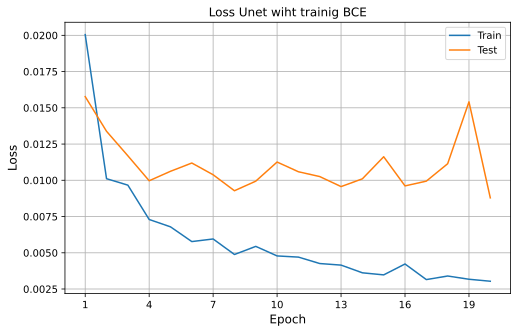

In [ ]:
title = 'Loss Unet wiht trainig BCE'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Loss'
plot([train_loss, test_loss], [label1, label2], num_epoch, title, xlabel, ylabel)

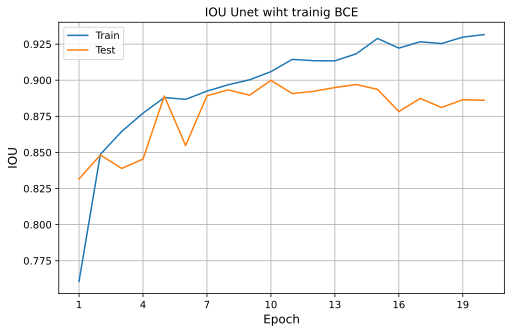

In [ ]:
title = 'IOU Unet wiht trainig BCE'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'IOU'
plot([train_metric, test_metric], [label1, label2], num_epoch, title, xlabel, ylabel)

In [ ]:
model.eval()   

inputs, labels = next(iter(test_data_loader))
inputs = inputs.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)

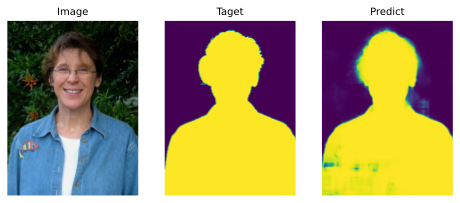

In [ ]:
show_res(inputs[0], labels[0], pred[0])

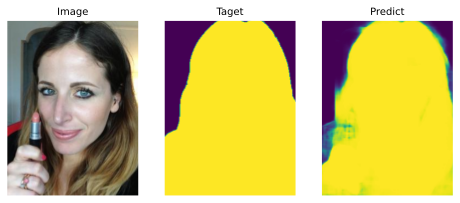

In [ ]:
show_res(inputs[4], labels[4], pred[4])

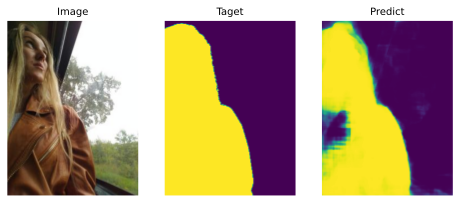

In [ ]:
show_res(inputs[5], labels[5], pred[5])

### **Dice Loss**

In [ ]:
model = UNet().to(device)
criterion_dice = DiceLoss(with_logits=True, reduction='mean', eps=1e-7)
val_criterion = IOU()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

In [ ]:
train_loss, train_metric, test_loss, test_metric = train(model, train_data_loader, test_data_loader, num_epoch, 
                                                         criterion_dice, val_criterion, optimizer, device)

Epoch 1
Train loss: 0.02278013589205565
Test loss: 0.016179251015609037
Test iou: 0.6039797329733557
Epoch 2
Train loss: 0.015371036838602137
Test loss: 0.013160687177739244
Test iou: 0.7208630987938415
Epoch 3
Train loss: 0.008655562544310534
Test loss: 0.007468568676329674
Test iou: 0.8001416997706636
Epoch 4
Train loss: 0.006719455912157341
Test loss: 0.006505230375638245
Test iou: 0.8225817578904172
Epoch 5
Train loss: 0.005917359071749228
Test loss: 0.005826631970439397
Test iou: 0.8387018974791182
Epoch 6
Train loss: 0.005899802995500741
Test loss: 0.005917359381280047
Test iou: 0.836744173198727
Epoch 7
Train loss: 0.005774849711192979
Test loss: 0.005805525902315234
Test iou: 0.8394726489452605
Epoch 8
Train loss: 0.005405331877646623
Test loss: 0.005955391002039538
Test iou: 0.8359246964150286
Epoch 9
Train loss: 0.005346739112778946
Test loss: 0.00542345310145236
Test iou: 0.8491005322611924
Epoch 10
Train loss: 0.00504069426269443
Test loss: 0.005860896715035676
Test iou: 0.

In [ ]:
PATH = '../content/drive/MyDrive/unet/'
torch.save(model.state_dict(), PATH + 'unet_dl.pth')

with open(PATH + "unet_train_loss_dl.txt", "w") as file:
    print(*train_loss, file=file)

with open(PATH + "unet_test_loss_dl.txt", "w") as file:
    print(*test_loss, file=file)

with open(PATH + "unet_train_metric_dl.txt", "w") as file:
    print(*test_metric, file=file)

with open(PATH + "unet_test_metric_dl.txt", "w") as file:
    print(*test_metric, file=file)

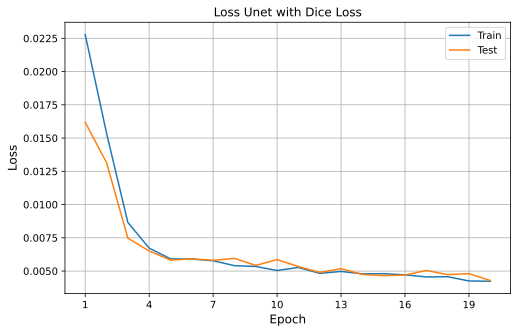

In [ ]:
title = 'Loss Unet with Dice Loss'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Loss'
plot([train_loss, test_loss], [label1, label2], num_epoch, title, xlabel, ylabel)

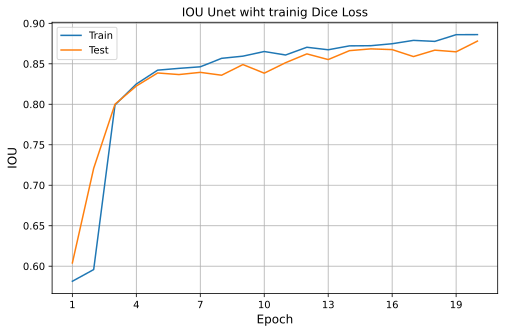

In [ ]:
title = 'IOU Unet wiht trainig Dice Loss'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'IOU'
plot([train_metric, test_metric], [label1, label2], num_epoch, title, xlabel, ylabel)

In [ ]:
model.eval()   

inputs, labels = next(iter(test_data_loader))
inputs = inputs.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)

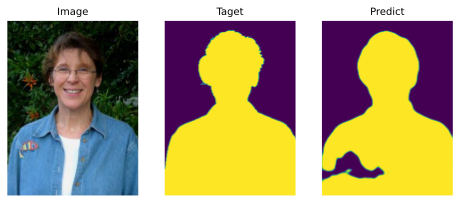

In [ ]:
show_res(inputs[0], labels[0], pred[0])

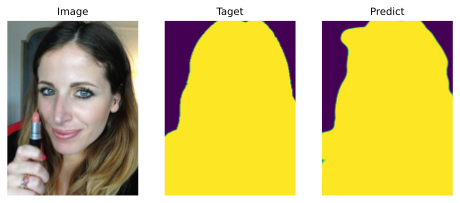

In [ ]:
show_res(inputs[4], labels[4], pred[4])

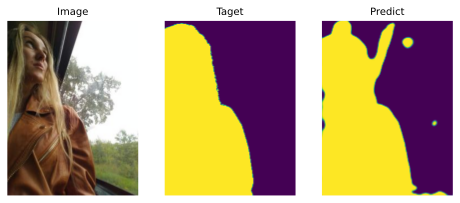

In [ ]:
show_res(inputs[5], labels[5], pred[5])

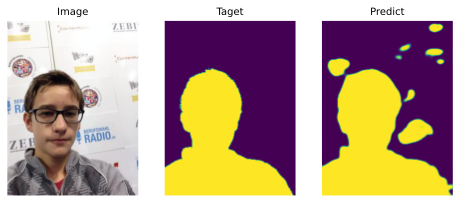

In [ ]:
show_res(inputs[3], labels[3], pred[3])

### **0.5 * BCEWithLogitsLoss + 0.5 * DiceLoss**

In [ ]:
class SummLoss(nn.Module):
    def __init__(self, criterions, weights):
        super().__init__()
        self.criterions = criterions
        self.weights = weights

    def forward(self, logits, true_labels):
        loss = 0
        for crit, w in zip(self.criterions, self.weights):
            loss += w*crit(logits, true_labels)
        return loss

In [ ]:
model = UNet().to(device)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dl = DiceLoss(with_logits=True, reduction='mean', eps=1e-7)
criterion = SummLoss([criterion_bce, criterion_dl], [0.5, 0.5])
val_criterion = IOU()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

In [ ]:
train_loss, train_metric, test_loss, test_metric = train(model, train_data_loader, test_data_loader, num_epoch, 
                                                         criterion, val_criterion, optimizer, device)

Epoch 1
Train loss: 0.030410672933967025
Test loss: 0.022744955323266643
Test iou: 0.6286358867131226
Epoch 2
Train loss: 0.015052681493538398
Test loss: 0.012348654316672196
Test iou: 0.8389621694037255
Epoch 3
Train loss: 0.008597842951615652
Test loss: 0.01157938926777941
Test iou: 0.8493738647893811
Epoch 4
Train loss: 0.007956110051384678
Test loss: 0.010183726642148715
Test iou: 0.8659881497105808
Epoch 6
Train loss: 0.007094958910235653
Test loss: 0.00959398518217371
Test iou: 0.8730502771147599
Epoch 7
Train loss: 0.006631665798249068
Test loss: 0.009400946134371115
Test iou: 0.8768024376943602
Epoch 8
Train loss: 0.006433160909348064
Test loss: 0.00926063151647013
Test iou: 0.8783606333090058
Epoch 9
Train loss: 0.006309880815722324
Test loss: 0.009051359925709717
Test iou: 0.8801618467831442
Epoch 10
Train loss: 0.00619846820279404
Test loss: 0.009550859213720822
Test iou: 0.8776515054364576
Epoch 11
Train loss: 0.005782268025256969
Test loss: 0.008690154985755894
Test iou: 0

In [ ]:
PATH = '../content/drive/MyDrive/unet/'
torch.save(model.state_dict(), PATH + 'unet_bce_dl.pth')

with open(PATH + "unet_train_loss_bce_dl.txt", "w") as file:
    print(*train_loss, file=file)

with open(PATH + "unet_test_loss_bce_dl.txt", "w") as file:
    print(*test_loss, file=file)

with open(PATH + "unet_train_metric_bce_dl.txt", "w") as file:
    print(*test_metric, file=file)

with open(PATH + "unet_test_metric_bce_dl.txt", "w") as file:
    print(*test_metric, file=file)

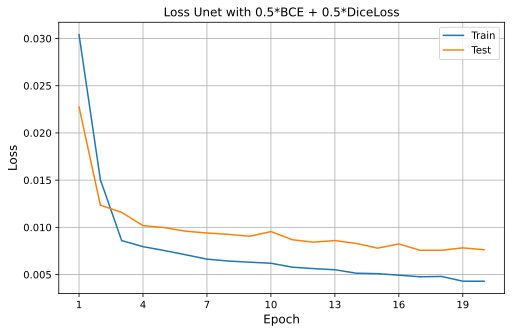

In [ ]:
title = 'Loss Unet with 0.5*BCE + 0.5*DiceLoss'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Loss'
plot([train_loss, test_loss], [label1, label2], num_epoch, title, xlabel, ylabel)

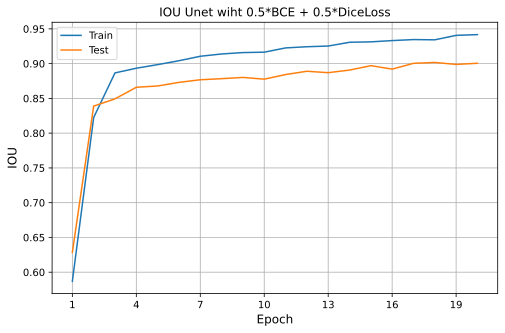

In [ ]:
title = 'IOU Unet wiht 0.5*BCE + 0.5*DiceLoss'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'IOU'
plot([train_metric, test_metric], [label1, label2], num_epoch, title, xlabel, ylabel)

In [ ]:
model.eval()   

inputs, labels = next(iter(test_data_loader))
inputs = inputs.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)

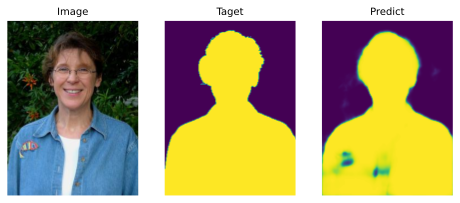

In [ ]:
show_res(inputs[0], labels[0], pred[0])

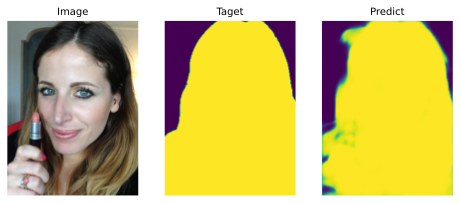

In [ ]:
show_res(inputs[4], labels[4], pred[4])

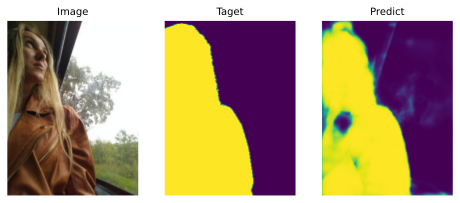

In [ ]:
show_res(inputs[5], labels[5], pred[5])

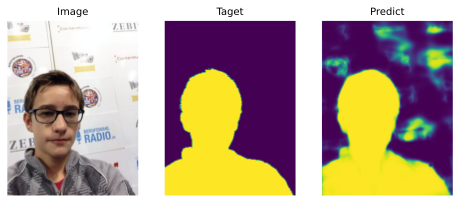

In [ ]:
show_res(inputs[3], labels[3], pred[3])

### **Сравнение**

In [ ]:
f = open('../content/drive/MyDrive/unet/unet_test_loss_bce.txt')
line = f.readlines()
test_loss_bce = []
for loss in line[0].split():
    test_loss_bce.append(float(loss))

f = open('../content/drive/MyDrive/unet/unet_test_loss_dl.txt')
line = f.readlines()
test_loss_dl = []
for loss in line[0].split():
    test_loss_dl.append(float(loss))

f = open('../content/drive/MyDrive/unet/unet_test_loss_bce_dl.txt')
line = f.readlines()
test_loss_bce_dl = []
for loss in line[0].split():
    test_loss_bce_dl.append(float(loss))

In [ ]:
f = open('../content/drive/MyDrive/unet/unet_test_metric_bce.txt')
line = f.readlines()
test_metric_bce = []
for loss in line[0].split():
    test_metric_bce.append(float(loss))

f = open('../content/drive/MyDrive/unet/unet_test_metric_dl.txt')
line = f.readlines()
test_metric_dl = []
for loss in line[0].split():
    test_metric_dl.append(float(loss))

f = open('../content/drive/MyDrive/unet/unet_test_metric_bce_dl.txt')
line = f.readlines()
test_metric_bce_dl = []
for loss in line[0].split():
    test_metric_bce_dl.append(float(loss))

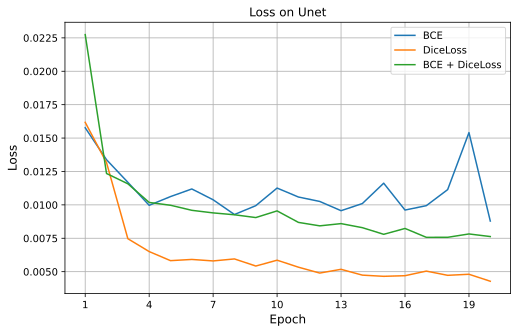

In [ ]:
title = 'Loss on Unet'
label1 = 'BCE'
label2 = 'DiceLoss'
label3 = 'BCE + DiceLoss'
xlabel = 'Epoch'
ylabel = 'Loss'
plot([test_loss_bce, test_loss_dl, test_loss_bce_dl], [label1, label2, label3], num_epoch, title, xlabel, ylabel)

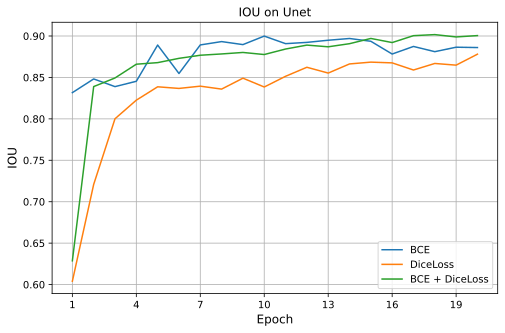

In [ ]:
title = 'IOU on Unet'
label1 = 'BCE'
label2 = 'DiceLoss'
label3 = 'BCE + DiceLoss'
xlabel = 'Epoch'
ylabel = 'IOU'
plot([test_metric_bce, test_metric_dl, test_metric_bce_dl], [label1, label2, label3], num_epoch, title, xlabel, ylabel)

Заметим, что наилучшее качество на тесте показал эксперимент, когда мы в качестве стратегии оптимизации использовали сумму энтропии и DiceLoss. То же видно из выведенных масок. Данные критерии "улучшают" и "дополняют" друг друга, исправляя ошибки. Если же оптимизироваться только по энтропии, то получим примерно такой же результат. Но если в качестве опитимизации выбрать DiceLoss, то можно уведеть, что сеть намного хуже научилась сегментировать изображения. Но отметим, что тогда она даёт более уверенные предсказания(на маске практически нет зелёных пятен).

## LinkNet (2 балла)

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

Обучите сеть и проведите анализ согласно предыдущему пункту.

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

In [ ]:
class DecoderBlockLinkNet(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x + left))
        return x

In [ ]:
class DecoderLinkNet(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlockLinkNet(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [ ]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = DecoderLinkNet(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

### **BCEWithLogitsLoss**

In [ ]:
num_epoch = 20
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LinkNet().to(device)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss(with_logits=True, reduction='mean', eps=1e-7)
val_criterion = IOU()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
train_loss, train_metric, test_loss, test_metric = train(model, train_data_loader, test_data_loader, num_epoch, 
                                                         criterion_bce, val_criterion, optimizer, device)

Epoch 1
Train loss: 0.01874572637456435
Test loss: 0.017484166415025156
Test iou: 0.8375427300202931
Epoch 2
Train loss: 0.010762442841573999
Test loss: 0.014089775000903623
Test iou: 0.8632355683238794
Epoch 3
Train loss: 0.009659166672715434
Test loss: 0.011916099816349382
Test iou: 0.8858057319695223
Epoch 4
Train loss: 0.007770378208822674
Test loss: 0.010464827800896151
Test iou: 0.8986628715028154
Epoch 5
Train loss: 0.00711004247268041
Test loss: 0.009660028291086779
Test iou: 0.9055441457329066
Epoch 6
Train loss: 0.006388397062266314
Test loss: 0.010759905509069457
Test iou: 0.8933188120524088
Epoch 7
Train loss: 0.006175373378727171
Test loss: 0.011238028394415024
Test iou: 0.8944377831533445
Epoch 8
Train loss: 0.005228426668930937
Test loss: 0.00896021195337282
Test iou: 0.9120812720440804
Epoch 9
Train loss: 0.00495895389881399
Test loss: 0.008890097445630013
Test iou: 0.9085499513233807
Epoch 10
Train loss: 0.004962899188200633
Test loss: 0.008817957965194757
Test iou: 0.

In [ ]:
PATH = '../content/drive/MyDrive/linknet/'
torch.save(model.state_dict(), PATH + 'linknet_bce.pth')

with open(PATH + "linknet_train_loss_bce.txt", "w") as file:
    print(*train_loss, file=file)

with open(PATH + "linknet_test_loss_bce.txt", "w") as file:
    print(*test_loss, file=file)

with open(PATH + "linknet_train_metric_bce.txt", "w") as file:
    print(*test_metric, file=file)

with open(PATH + "linknet_test_metric_bce.txt", "w") as file:
    print(*test_metric, file=file)

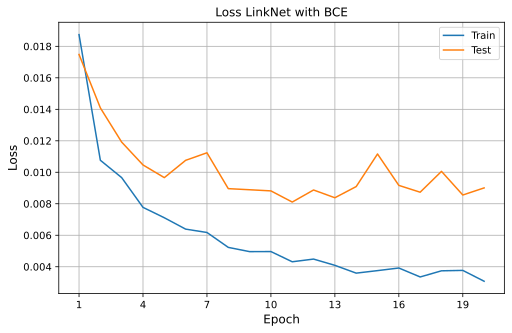

In [ ]:
title = 'Loss LinkNet with BCE'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Loss'
plot([train_loss, test_loss], [label1, label2], num_epoch, title, xlabel, ylabel)

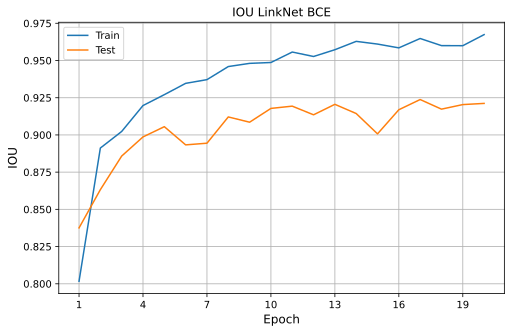

In [ ]:
title = 'IOU LinkNet BCE'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'IOU'
plot([train_metric, test_metric], [label1, label2], num_epoch, title, xlabel, ylabel)

In [ ]:
model.eval()   

inputs, labels = next(iter(test_data_loader))
inputs = inputs.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)

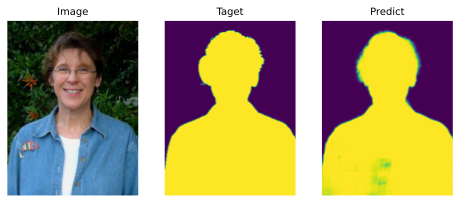

In [ ]:
show_res(inputs[0], labels[0], pred[0])

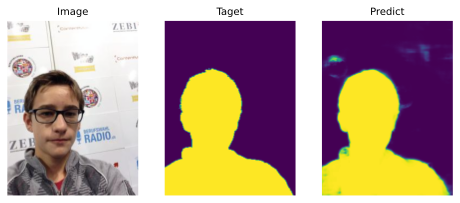

In [ ]:
show_res(inputs[3], labels[3], pred[3])

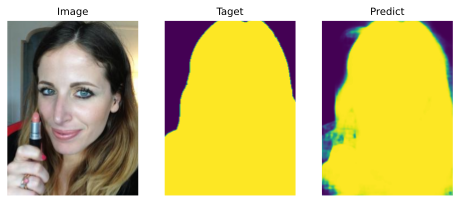

In [ ]:
show_res(inputs[4], labels[4], pred[4])

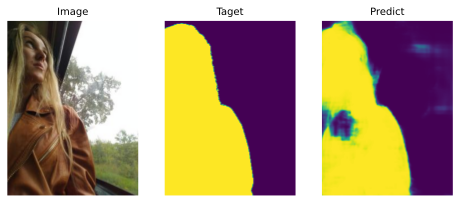

In [ ]:
show_res(inputs[5], labels[5], pred[5])

### **DiceLoss**

In [ ]:
model = LinkNet().to(device)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss(with_logits=True, reduction='mean', eps=1e-7)
val_criterion = IOU()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

In [ ]:
train_loss, train_metric, test_loss, test_metric = train(model, train_data_loader, test_data_loader, num_epoch, 
                                                         criterion_dice, val_criterion, optimizer, device)

Epoch 1
Train loss: 0.02202862007750405
Test loss: 0.015792483133627168
Test iou: 0.6039764999497866
Epoch 2
Train loss: 0.015463342070579528
Test loss: 0.0130987951518796
Test iou: 0.676276923916864
Epoch 3
Train loss: 0.0077581232123904754
Test loss: 0.006483355735210662
Test iou: 0.8243777904104679
Epoch 4
Train loss: 0.004601405434034489
Test loss: 0.005797094275765385
Test iou: 0.8407839646576144
Epoch 5
Train loss: 0.004065665081143379
Test loss: 0.005278452543924886
Test iou: 0.8531162789527406
Epoch 6
Train loss: 0.0038208426604116404
Test loss: 0.004947300762572187
Test iou: 0.8614508378590252
Epoch 7
Train loss: 0.0036218297495334236
Test loss: 0.005192306923105362
Test iou: 0.8555358386208826
Epoch 8
Train loss: 0.003530323831019578
Test loss: 0.004855750300360064
Test iou: 0.8641039327526769
Epoch 9
Train loss: 0.003469852849289223
Test loss: 0.004613517710925839
Test iou: 0.8698634627863024
Epoch 10
Train loss: 0.003322840208808581
Test loss: 0.004457229682317017
Test iou:

In [ ]:
PATH = '../content/drive/MyDrive/linknet/'
torch.save(model.state_dict(), PATH + 'linknet_dl.pth')

with open(PATH + "linknet_train_loss_dl.txt", "w") as file:
    print(*train_loss, file=file)

with open(PATH + "linknet_test_loss_dl.txt", "w") as file:
    print(*test_loss, file=file)

with open(PATH + "linknet_train_metric_dl.txt", "w") as file:
    print(*test_metric, file=file)

with open(PATH + "linknet_test_metric_dl.txt", "w") as file:
    print(*test_metric, file=file)

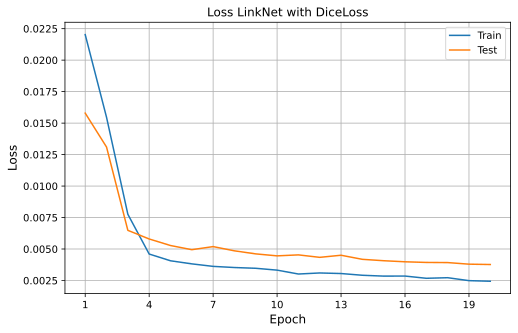

In [ ]:
title = 'Loss LinkNet with DiceLoss'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Loss'
plot([train_loss, test_loss], [label1, label2], num_epoch, title, xlabel, ylabel)

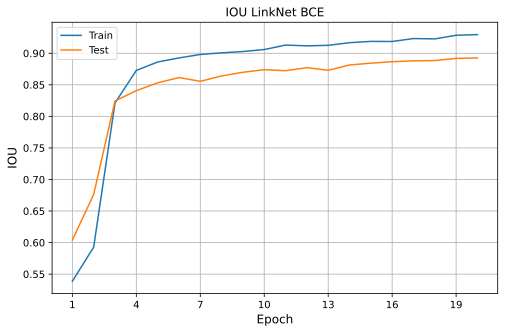

In [ ]:
title = 'IOU LinkNet BCE'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'IOU'
plot([train_metric, test_metric], [label1, label2], num_epoch, title, xlabel, ylabel)

In [ ]:
model.eval()   

inputs, labels = next(iter(test_data_loader))
inputs = inputs.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)

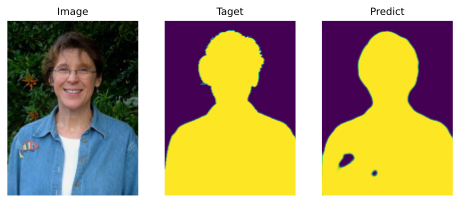

In [ ]:
show_res(inputs[0], labels[0], pred[0])

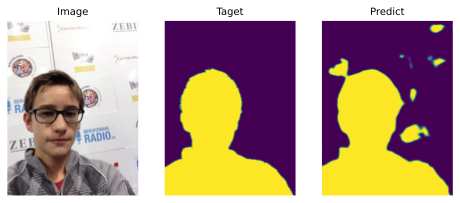

In [ ]:
show_res(inputs[3], labels[3], pred[3])

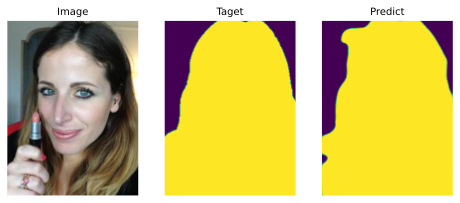

In [ ]:
show_res(inputs[4], labels[4], pred[4])

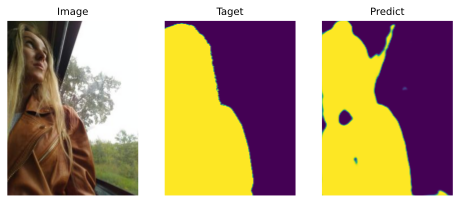

In [ ]:
show_res(inputs[5], labels[5], pred[5])

### **0.5 * BCEWithLogitsLoss + 0.5 * DiceLoss**

In [ ]:
model = LinkNet().to(device)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dl = DiceLoss(with_logits=True, reduction='mean', eps=1e-7)
criterion = SummLoss([criterion_bce, criterion_dl], [0.5, 0.5])
val_criterion = IOU()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
train_loss, train_metric, test_loss, test_metric = train(model, train_data_loader, test_data_loader, num_epoch, 
                                                         criterion, val_criterion, optimizer, device)

Epoch 1
Train loss: 0.027882954875628155
Test loss: 0.020100969160702212
Test iou: 0.7572688447668198
Epoch 2
Train loss: 0.01226280023102407
Test loss: 0.013944721496697014
Test iou: 0.8212166982339629
Epoch 3
Train loss: 0.009321766103859302
Test loss: 0.011714124510474239
Test iou: 0.8463939707329933
Epoch 4
Train loss: 0.008352761511449461
Test loss: 0.010843012032779396
Test iou: 0.8580965285605573
Epoch 5
Train loss: 0.00808883610698912
Test loss: 0.010712342693450604
Test iou: 0.8589180276748982
Epoch 6
Train loss: 0.007525111144339597
Test loss: 0.011216193437576294
Test iou: 0.8560002306674389
Epoch 7
Train loss: 0.007502505288079933
Test loss: 0.0106490968812442
Test iou: 0.8613590348696878
Epoch 8
Train loss: 0.007201499845142718
Test loss: 0.009793758075288001
Test iou: 0.8713028684575507
Epoch 9
Train loss: 0.006910713414351145
Test loss: 0.00937128669403969
Test iou: 0.8772621154785156
Epoch 10
Train loss: 0.00656242242289914
Test loss: 0.00958473060993438
Test iou: 0.875

In [ ]:
PATH = '../content/drive/MyDrive/linknet/'
torch.save(model.state_dict(), PATH + 'linknet_bce_dl.pth')

with open(PATH + "linknet_train_loss_bce_dl.txt", "w") as file:
    print(*train_loss, file=file)

with open(PATH + "linknet_test_loss_bce_dl.txt", "w") as file:
    print(*test_loss, file=file)

with open(PATH + "linknet_train_metric_bce_dl.txt", "w") as file:
    print(*test_metric, file=file)

with open(PATH + "linknet_test_metric_bce_dl.txt", "w") as file:
    print(*test_metric, file=file)

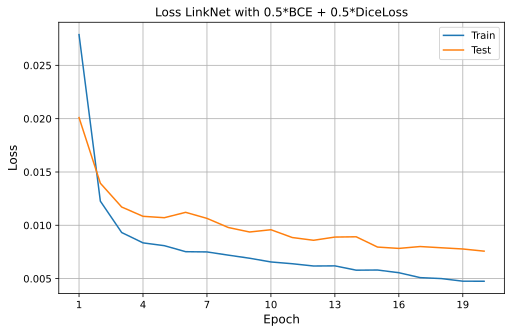

In [ ]:
title = 'Loss LinkNet with 0.5*BCE + 0.5*DiceLoss'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'Loss'
plot([train_loss, test_loss], [label1, label2], num_epoch, title, xlabel, ylabel)

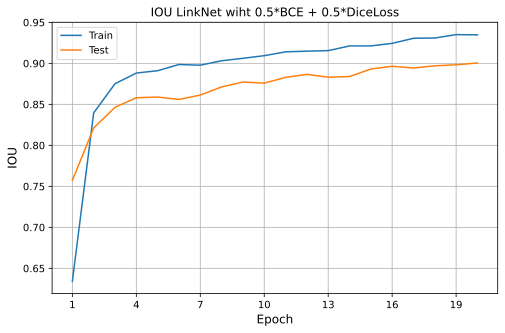

In [ ]:
title = 'IOU LinkNet wiht 0.5*BCE + 0.5*DiceLoss'
label1 = 'Train'
label2 = 'Test'
xlabel = 'Epoch'
ylabel = 'IOU'
plot([train_metric, test_metric], [label1, label2], num_epoch, title, xlabel, ylabel)

In [ ]:
model.eval()   

inputs, labels = next(iter(test_data_loader))
inputs = inputs.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)

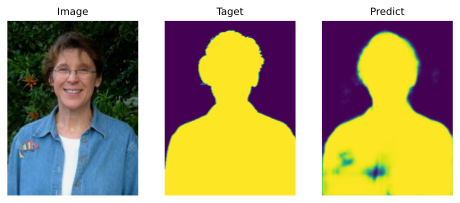

In [ ]:
show_res(inputs[0], labels[0], pred[0])

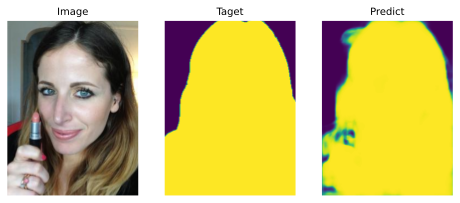

In [ ]:
show_res(inputs[4], labels[4], pred[4])

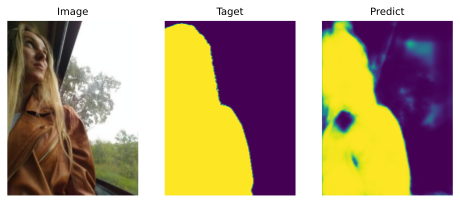

In [ ]:
show_res(inputs[5], labels[5], pred[5])

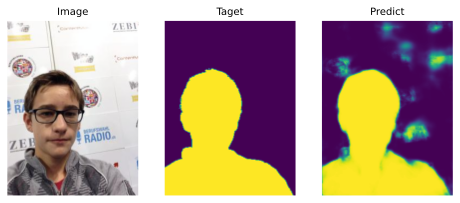

In [ ]:
show_res(inputs[3], labels[3], pred[3])

### **Сравнение функций ошибок**

In [ ]:
f = open('../content/drive/MyDrive/linknet/linknet_test_loss_bce.txt')
line = f.readlines()
test_loss_bce_link = []
for loss in line[0].split():
    test_loss_bce_link.append(float(loss))

f = open('../content/drive/MyDrive/linknet/linknet_test_loss_dl.txt')
line = f.readlines()
test_loss_dl_link = []
for loss in line[0].split():
    test_loss_dl_link.append(float(loss))

f = open('../content/drive/MyDrive/linknet/linknet_test_loss_bce_dl.txt')
line = f.readlines()
test_loss_bce_dl_link = []
for loss in line[0].split():
    test_loss_bce_dl_link.append(float(loss))

In [20]:
f = open('../content/drive/MyDrive/linknet/linknet_test_metric_bce.txt')
line = f.readlines()
test_metric_bce_link = []
for loss in line[0].split():
    test_metric_bce_link.append(float(loss))

f = open('../content/drive/MyDrive/linknet/linknet_test_metric_dl.txt')
line = f.readlines()
test_metric_dl_link = []
for loss in line[0].split():
    test_metric_dl_link.append(float(loss))

f = open('../content/drive/MyDrive/linknet/linknet_test_metric_bce_dl.txt')
line = f.readlines()
test_metric_bce_dl_link = []
for loss in line[0].split():
    test_metric_bce_dl_link.append(float(loss))

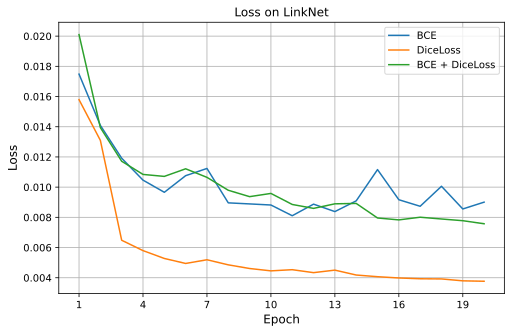

In [ ]:
title = 'Loss on LinkNet'
label1 = 'BCE'
label2 = 'DiceLoss'
label3 = 'BCE + DiceLoss'
xlabel = 'Epoch'
ylabel = 'Loss'
plot([test_loss_bce_link, test_loss_dl_link, test_loss_bce_dl_link], [label1, label2, label3], num_epoch, title, xlabel, ylabel)

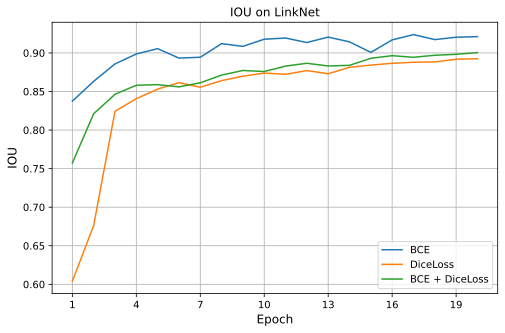

In [ ]:
title = 'IOU on LinkNet'
label1 = 'BCE'
label2 = 'DiceLoss'
label3 = 'BCE + DiceLoss'
xlabel = 'Epoch'
ylabel = 'IOU'
plot([test_metric_bce_link, test_metric_dl_link, test_metric_bce_dl_link], [label1, label2, label3], num_epoch, title, xlabel, ylabel)

Здесть можно привести аналогичный вывод, что и для Unet. Однако, заметим, что наибольшее качество работы показал энтропийный критерий ошибки. Если к нему добавить ещё DiceLoss, качество немного упадёт.

### **Unet vc LinkNet**

In [21]:
f = open('../content/drive/MyDrive/unet/unet_test_metric_bce.txt')
line = f.readlines()
test_metric_bce_u = []
for loss in line[0].split():
    test_metric_bce_u.append(float(loss))

f = open('../content/drive/MyDrive/unet/unet_test_metric_dl.txt')
line = f.readlines()
test_metric_dl_u = []
for loss in line[0].split():
    test_metric_dl_u.append(float(loss))

f = open('../content/drive/MyDrive/unet/unet_test_metric_bce_dl.txt')
line = f.readlines()
test_metric_bce_dl_u = []
for loss in line[0].split():
    test_metric_bce_dl_u.append(float(loss))

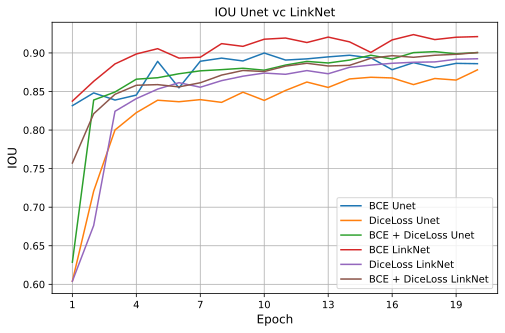

In [26]:
title = 'IOU Unet vc LinkNet'
label1 = 'BCE Unet'
label2 = 'DiceLoss Unet'
label3 = 'BCE + DiceLoss Unet'

label4 = 'BCE LinkNet'
label5 = 'DiceLoss LinkNet'
label6 = 'BCE + DiceLoss LinkNet'

xlabel = 'Epoch'
ylabel = 'IOU'
plot([test_metric_bce_u, test_metric_dl_u, test_metric_bce_dl_u, test_metric_bce_link, test_metric_dl_link, test_metric_bce_dl_link], 
     [label1, label2, label3, label4, label5, label6], num_epoch, title, xlabel, ylabel)

Заметим, что качество работы примерно одинаково. Это же видно из результатов работ сетей. Они ошибаются примерно в тех же местах и выдают похожие ответы. Однако всё же LinkNet показывает на тесте более хорошее качество. К тому же, она намного быстрее обучается.

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

**Ответ**\
1) Считается, что данные непрерывны и однородны, имеют похожую структуру. Такие как изображения, тексты, временные ряды.\
2) Меньше параметров и число операций, таким образом, повышаются вычислительные способности. Также учитывается локальность признаков.\
3) Обычные табличные данные, где могут встречаться совершенно разные признаки независимые друг от друга.

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

${f(\cdot)}$:\
Произведение $y = Wx^{(i)}$ даёт вектор размерности $10^3$, т.е. $y \in \mathbb{R}^{1000}$. А сигмоида не меняет размерности. Для каждого элемента вектора $y$ необходимо произвести 100 операций умножения и 99 сложения. Т.е. всего 199 $\cdot$ 1000 операций. И далее еще 1000 раз посчитать сигмоиду. Таким образом, всего 200000 операций. В полносвязном слое у нас обучается только матрица $W$. Таким образом у нас $10^5$ обучаемых параметров.

${g(\cdot)}$:\
Каждая из свёрток имеет размерность ${3\times 1}$, т.е. ${z_j \in \mathbb{R}^{3}}$. Так получим всего 30 параметров для обучения. Так как мы применяем паддинг 1, то получим, что выходной вектор имеет ту же размерность что и $x$. Тогда после применения функции $g(\cdot)$ получим матрицу размерности ${100\times 10}$ (т.к. свёртки конкатенируются). Получим для каждого элемента этого вектора по 3 операции умножения и 2 сложения. Т.е. всего $5*10^3$. И далее ещё 1000 операция в сигмоиде. Итого 6000 оперций.

**Ответ**: $f(\cdot): 1)\mathbb{R}^{1000} \;\; 2)10^5 \;\; 3)2\cdot 10^5 $\
$g(\cdot): 1)\mathbb{R}^{100\times 10} \;\; 2)30 \;\; 3)6\cdot 10^3 $

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).